Este programa corre un modelo ARIMA sobre la serie de supermercados a precios corrientes considerando a futuro distintos escenarios.
Se toma la serie hasta JUNIO 2023 (ultimo dato disponible)

In [2]:
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA


Cargo la serie y defino la columna de fechas

In [3]:
series = read_csv('serieScorr.csv', encoding= 'unicode_escape', delimiter=',') 
series['indice_tiempo'] = pd.to_datetime(series['indice_tiempo'])
ventas=series['ventas_precios_corrientes']

Grafico

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   indice_tiempo              330 non-null    datetime64[ns]
 1   ventas_precios_corrientes  330 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.3 KB


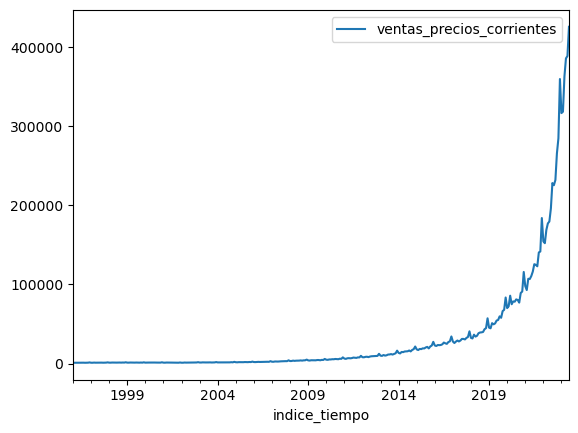

In [4]:
series.set_index('indice_tiempo').plot()
series.info()


Observo que la variancia no es constante a traves del tiempo, por lo que aplico logaritmo.
RECORDAR APLICAR FUNCION INVERSA A LA HORA DE OBTENER PRONOSTICOS.

<Axes: >

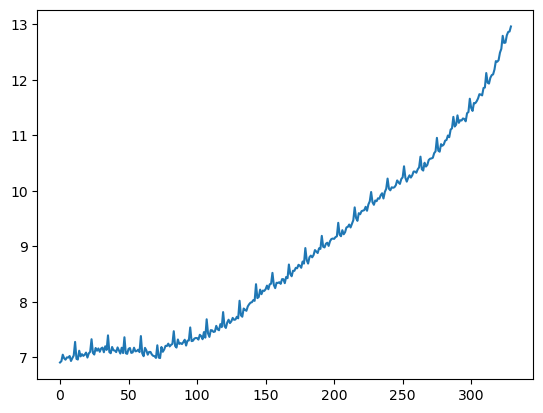

In [5]:
import numpy as np
ventas = np.log(ventas) # don't forget to transform the data back when making real predictions
ventas.plot()


Claramente la serie no es estacionaria (no mantiene la media a lo largo del tiempo), por lo que deberemos diferenciar. The ACF plot shows the correlations with the lags are high and positive with very slow decay. While the PACF plot shows the partial autocorrelations have a single spike at lag 1. These are both signs of a trended time series. So our time series is not stationary.

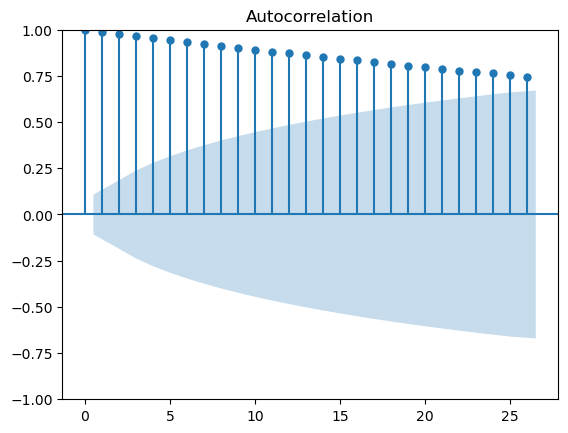

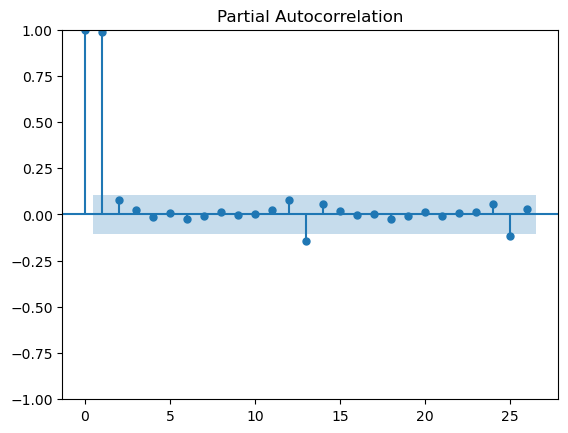

In [6]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(ventas)
pacf_original = plot_pacf(ventas)


Testeo estacionariedad con Augmented Dicker Fuller Test

In [7]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(ventas)
print(f'p-value: {adf_test[1]}')

p-value: 0.9990513228864484


<Axes: >

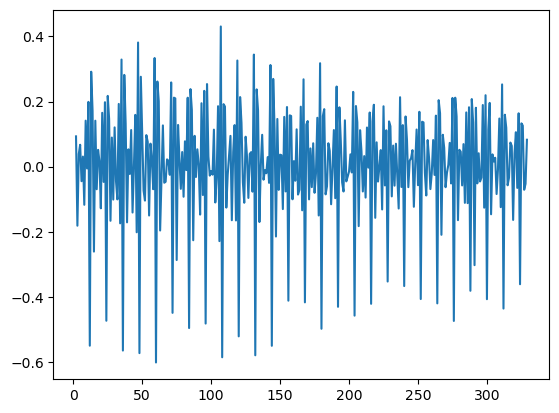

In [8]:
ventas_diff = ventas.diff().dropna()
ventas_diff2= ventas_diff.diff().dropna()
ventas_diff2.plot()


Testeo estacionariedad con Augmented Dicker Fuller Test de la serie diferenciada y veo que todavia no pasa
el testeo de Estacion.

In [9]:
adf_test = adfuller(ventas_diff)
print(f'p-value: {adf_test[1]}')

p-value: 0.9422191039625115


Diferencio 2 veces y veo que esta vez si el p valor es menor a 0.05.

In [10]:
adf_test = adfuller(ventas_diff2)
print(f'p-value: {adf_test[1]}')

p-value: 1.043486924015174e-14


Sigamos entonces analizando para ver qué valores vamos a tomar para hacer el grid search de arima

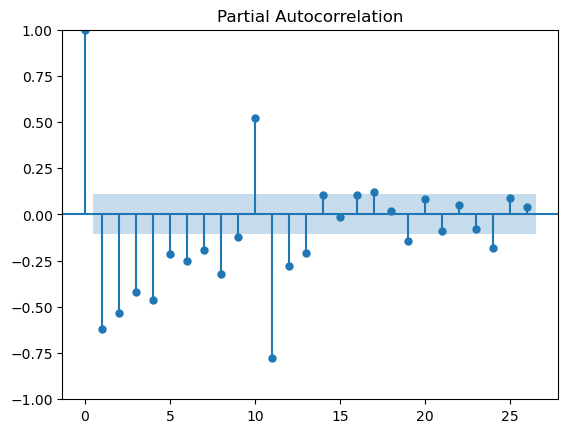

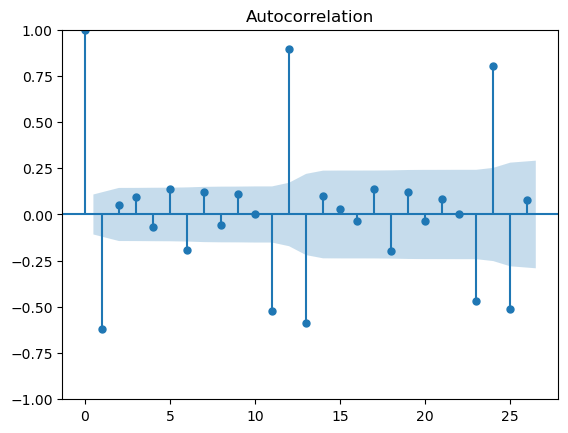

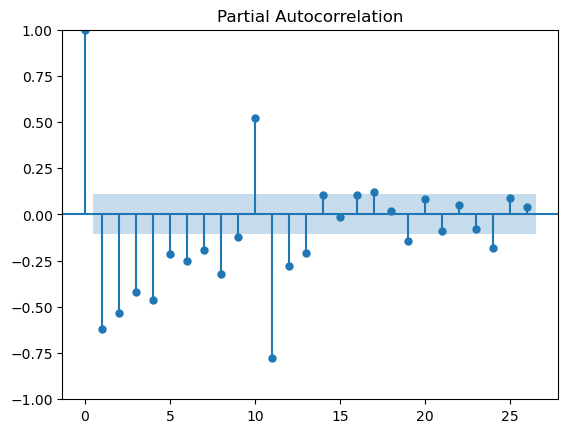

In [11]:
plot_acf(ventas_diff2)
plot_pacf(ventas_diff2)

In [12]:
import pmdarima as pm
auto_arima = pm.auto_arima(ventas,stepwise=True,seasonal=True, m=12)
auto_arima

ARIMA(order=(2, 2, 2), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [13]:
print(auto_arima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  330
Model:             SARIMAX(2, 2, 2)x(2, 0, 2, 12)   Log Likelihood                 641.408
Date:                            Sat, 09 Sep 2023   AIC                          -1264.816
Time:                                    17:32:58   BIC                          -1230.679
Sample:                                         0   HQIC                         -1251.196
                                            - 330                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9737      0.118     -8.274      0.000      -1.204      -0.743
ar.L2         -0.5325      0.066   

The residuals look random in general, and their density looks normally distributed with a mean of around 0.

c:\Users\dolor\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dolor\miniconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                     
Dep. Variable:        ventas_precios_corrientes   No. Observations:                  330
Model:             ARIMA(2, 2, 2)x(2, 0, 2, 12)   Log Likelihood                 641.408
Date:                          Sat, 09 Sep 2023   AIC                          -1264.816
Time:                                  17:33:10   BIC                          -1230.679
Sample:                                       0   HQIC                         -1251.196
                                          - 330                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9737      0.118     -8.274      0.000      -1.204      -0.743
ar.L2         -0.5325      0.066     -8.122      0.

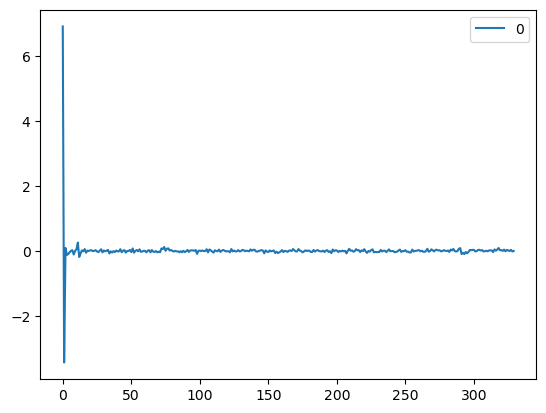

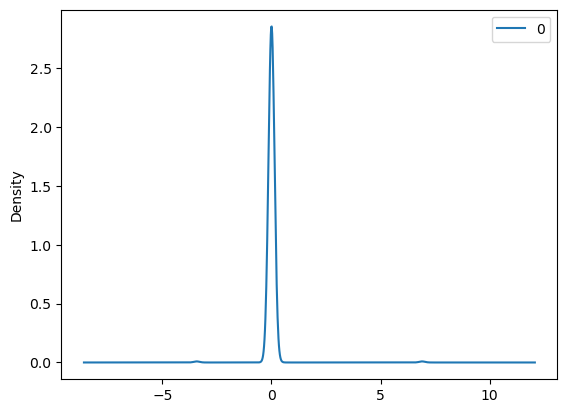

                0
count  330.000000
mean     0.012022
std      0.426697
min     -3.429576
25%     -0.017380
50%      0.000859
75%      0.022741
max      6.906525


In [14]:
# fit model
model = ARIMA(ventas, order=(2,2,2), seasonal_order=(2,0,2,12))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

The lower lags barely show any significant ‘spikes’.
These show that the residuals are close to white noise. We are ready to forecast with this model ARIMA

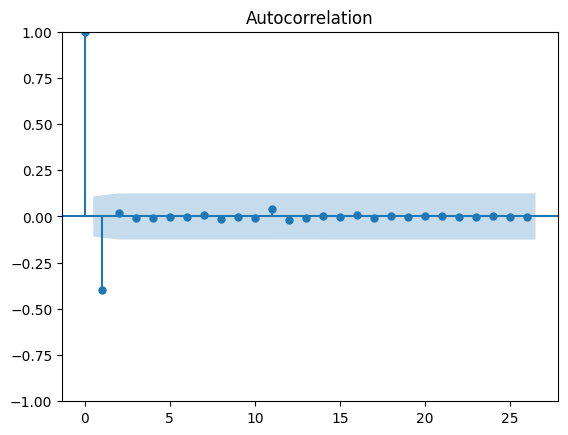

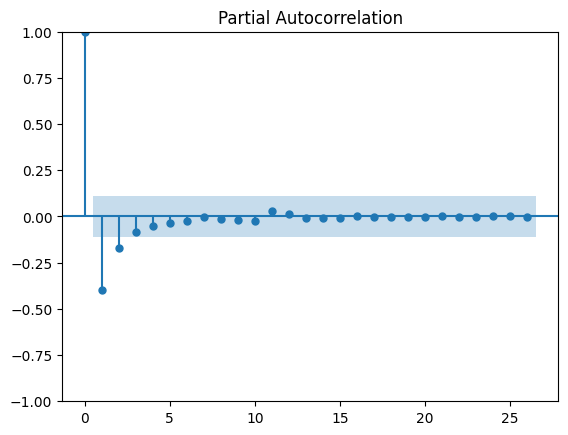

In [33]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

*********GRIDSEARCH********

Establezco los valores para evaluar. Uso lo obtenido en los resultados anteriores

Veo los residuos del modelo elegido Best ARIMA(2, 2, 2) (2, 1, 2, 12) RMSE=0.033

c:\Users\dolor\miniconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                     
Dep. Variable:        ventas_precios_corrientes   No. Observations:                  330
Model:             ARIMA(2, 2, 2)x(2, 1, 2, 12)   Log Likelihood                 646.763
Date:                          Sat, 09 Sep 2023   AIC                          -1275.526
Time:                                  17:33:37   BIC                          -1241.724
Sample:                                       0   HQIC                         -1262.022
                                          - 330                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8729      0.159     -5.482      0.000      -1.185      -0.561
ar.L2         -0.4409      0.081     -5.428      0.

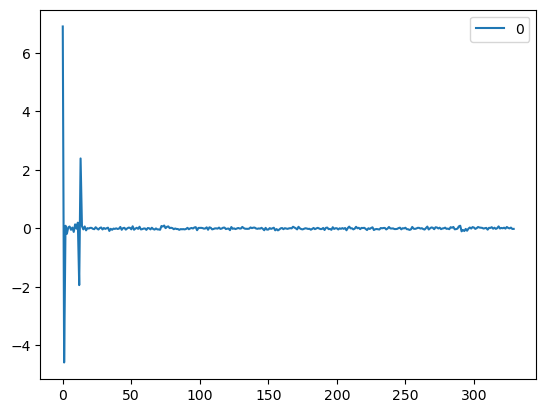

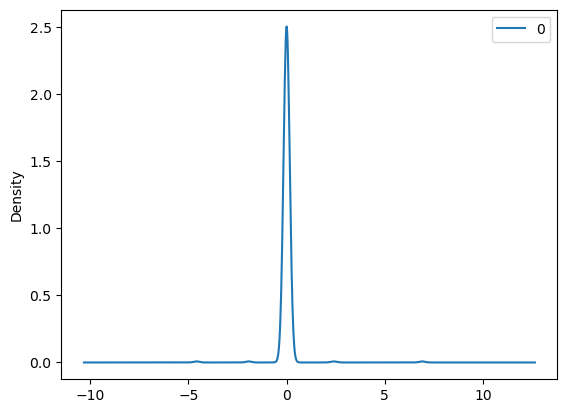

                0
count  330.000000
mean     0.010924
std      0.488656
min     -4.580663
25%     -0.019134
50%      0.001439
75%      0.022578
max      6.906525


In [15]:
# fit model
model = ARIMA(ventas, order=(2,2,2), seasonal_order=(2,1,2,12))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

Una vez elegido el modelo efectuamos las predicciones. Recordemos que debemos hacer exp ya que para 
estabilizar varianzas aplicamos ln al inicio. 


In [16]:
import warnings
from math import sqrt
from pandas import read_csv
#from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
model = ARIMA(ventas, order=(2,2,2), seasonal_order=(2,1,2,12))
model_fit = model.fit()


c:\Users\dolor\miniconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [127]:
series['lnventas']=ventas
series

,indice_tiempo,ventas_precios_corrientes,lnventas
0,1996-01-01,998.770000,6.906525
1,1996-02-01,1022.710000,6.930211
2,1996-03-01,1149.270000,7.046882
3,1996-04-01,1077.440000,6.982343
4,1996-05-01,1050.080000,6.956622
...,...,...,...
320,2022-09-01,232153.157225,12.355153
321,2022-10-01,265665.688890,12.489994
322,2022-11-01,284825.273120,12.559631
323,2022-12-01,359730.267987,12.793110


ESCENARIO 1 Hacemos el pronostico para 10 obs, las primeras 4 las dejo igual (hasta octubre) y a las 6 siguientes le saco el porcentaje de inflación (que es a julio el 113%)
Invierto aplicando Exponencial

In [19]:
import math
yhat = model_fit.forecast(10)
yhat=yhat.apply(math.exp)
yhat


330    480523.451190
331    494621.844565
332    510617.812334
333    590986.502624
334    637664.528903
335    815213.839274
336    699038.533623
337    715422.215165
338    849122.076675
339    852069.856941
Name: predicted_mean, dtype: float64

Armo ESC1  como dijimos

In [44]:
serieESC1 = read_csv('serieESC1.csv', encoding= 'unicode_escape', delimiter=',') 
serieESC1['indice_tiempo'] = pd.to_datetime(serieESC1['indice_tiempo'])
ventasESC1=serieESC1['ventas_precios_corrientes']
ventasESC1 = np.log(ventasESC1)
model = ARIMA(ventasESC1, order=(2,2,2), seasonal_order=(2,1,2,12))
model_fit = model.fit()


c:\Users\dolor\miniconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
import math
yhatESC1 = model_fit.forecast(6)
yhatESC1=yhatESC1.apply(math.exp)
yhatESC1

340    8.233874e+05
341    8.907817e+05
342    9.599607e+05
343    1.011366e+06
344    1.023569e+06
345    1.190104e+06
Name: predicted_mean, dtype: float64

<Axes: xlabel='dates'>

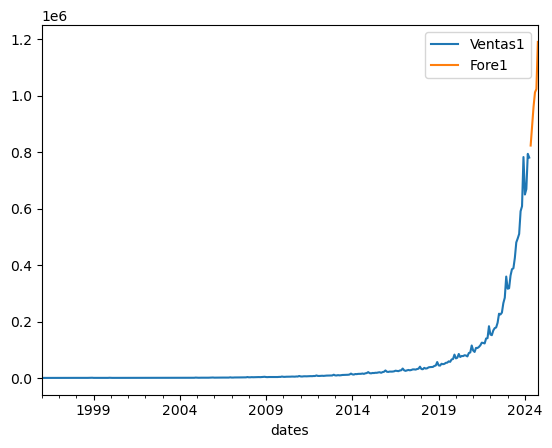

In [69]:
v1=list(serieESC1['ventas_precios_corrientes'])
E1={'dates':pd.date_range(start='1996-01-01', end='2024-10-01', freq='1MS'), 'Ventas1':v1+[None]*6,'Fore1': [None]*len(serieESC1) + list(yhatESC1)}
E1=pd.DataFrame(data=E1)
E1.set_index('dates').plot()

Text(0.5, 1.0, 'Ventas en Supermercados en millones de pesos. Pronóstico de 6 meses')

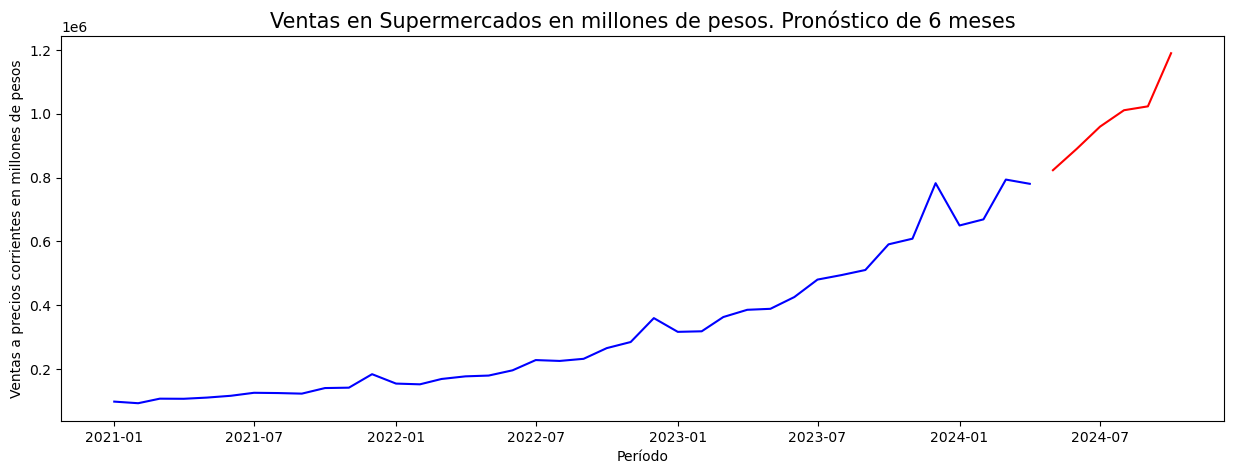

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
E11=E1[300:] #para ver la ultima parte
plt.figure(figsize=(15,5))
sns.lineplot(x='dates', y='Ventas1', data=E11, color='b')
sns.lineplot(x='dates', y='Fore1', data=E11, color='r')
plt.ylabel('Ventas a precios corrientes en millones de pesos', fontsize=10)
plt.xlabel('Período')
plt.title('Ventas en Supermercados en millones de pesos. Pronóstico de 6 meses', fontsize=15)

ESCENARIO 2 Hacemos el pronostico para 10 obs, las primeras 4 las dejo igual (hasta octubre) y a las 6 siguientes le agrego un porcentaje de inflación adicional que seria el aceleramiento de la misma. Le agrego 0.5,1, 1.5 ,2,2.5,3 a los meses de diciembre hasta abril
Invierto aplicando Exponencial

In [45]:
serieESC2 = read_csv('serieESC2.csv', encoding= 'unicode_escape', delimiter=',') 
serieESC2['indice_tiempo'] = pd.to_datetime(serieESC2['indice_tiempo'])
ventasESC2=serieESC2['ventas_precios_corrientes']
ventasESC2 = np.log(ventasESC2)
model = ARIMA(ventasESC2, order=(2,2,2), seasonal_order=(2,1,2,12))
model_fit = model.fit()

c:\Users\dolor\miniconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


pronostico 6 meses mas

In [46]:
import math
yhatESC2 = model_fit.forecast(6)
yhatESC2=yhatESC2.apply(math.exp)
yhatESC2

340    9.228161e+05
341    1.005807e+06
342    1.093734e+06
343    1.160068e+06
344    1.182763e+06
345    1.385048e+06
Name: predicted_mean, dtype: float64

Grafico

<Axes: xlabel='dates'>

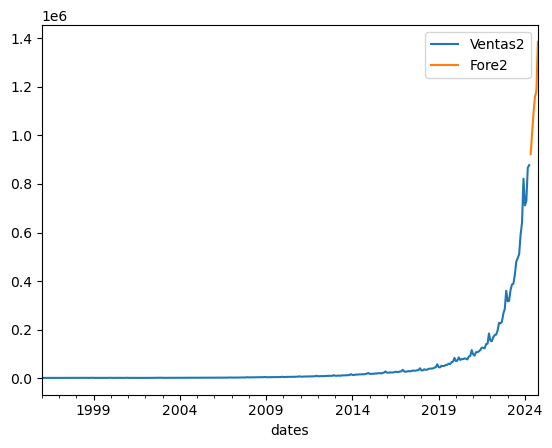

In [71]:
v=list(serieESC2['ventas_precios_corrientes'])
E2={'dates':pd.date_range(start='1996-01-01', end='2024-10-01', freq='1MS'), 'Ventas2':v+[None]*6,'Fore2': [None]*len(serieESC2) + list(yhatESC2)}
E2=pd.DataFrame(data=E2)
E2.set_index('dates').plot()

Text(0.5, 1.0, 'Ventas en Supermercados en millones de pesos. Pronóstico de 6 meses')

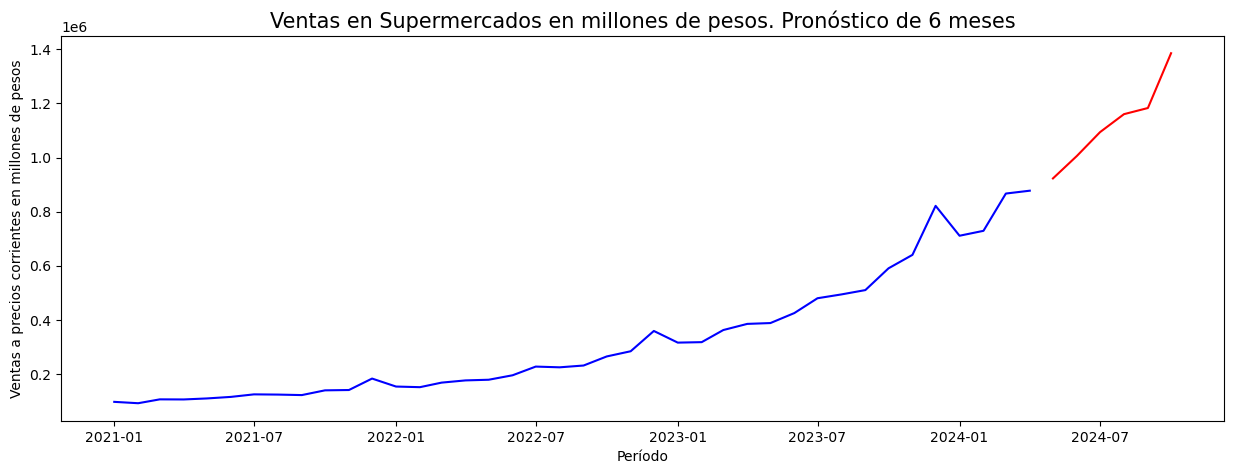

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
E12=E2[300:] #para ver la ultima parte
plt.figure(figsize=(15,5))
sns.lineplot(x='dates', y='Ventas2', data=E12, color='b')
sns.lineplot(x='dates', y='Fore2', data=E12, color='r')
plt.ylabel('Ventas a precios corrientes en millones de pesos', fontsize=10)
plt.xlabel('Período')
plt.title('Ventas en Supermercados en millones de pesos. Pronóstico de 6 meses', fontsize=15)

Text(0.5, 1.0, 'Ventas en Supermercados en millones de pesos. Pronóstico de 6 meses con 2 Escenarios')

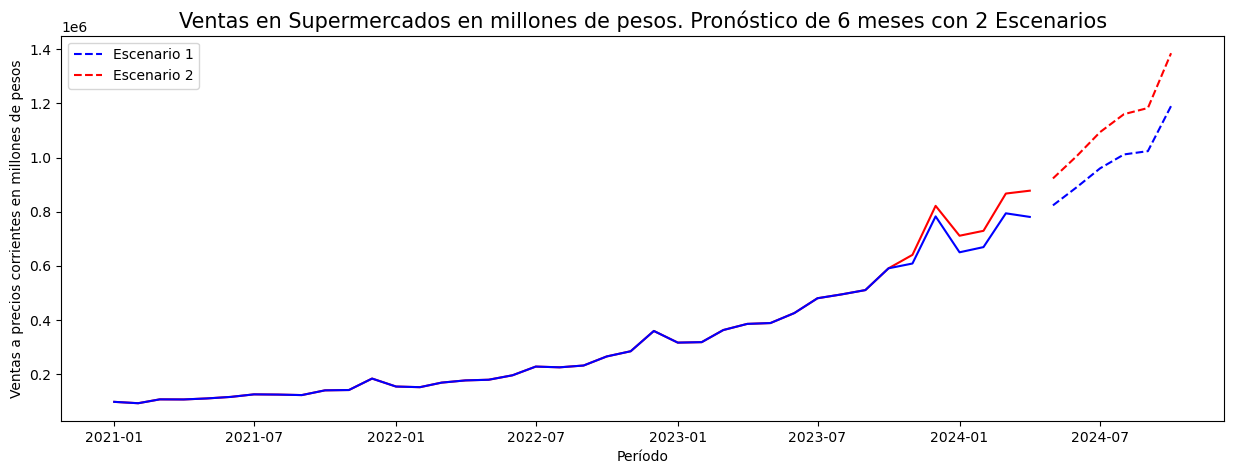

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
E12=E2[300:] #para ver la ultima parte
plt.figure(figsize=(15,5))
sns.lineplot(x='dates', y='Ventas2', data=E12, color='r')
sns.lineplot(x='dates', y='Ventas1', data=E11, color='b')
sns.lineplot(x='dates', y='Fore1', data=E11, color='b', linestyle='--', label="Escenario 1")
sns.lineplot(x='dates', y='Fore2', data=E12, color='r', linestyle='--', label="Escenario 2")
plt.ylabel('Ventas a precios corrientes en millones de pesos', fontsize=10)
plt.xlabel('Período')
plt.title('Ventas en Supermercados en millones de pesos. Pronóstico de 6 meses con 2 Escenarios', fontsize=15)

In [94]:

EF={'dates':pd.date_range(start='2024-05-01', end='2024-10-01', freq='1MS'), 'Pronóstico Escenario1': list(yhatESC1), 'Pronóstico Escenario2': list(yhatESC2)}
EF=pd.DataFrame(data=EF)
EF

,dates,Pronóstico Escenario1,Pronóstico Escenario2
0,2024-05-01,8.233874e+05,9.228161e+05
1,2024-06-01,8.907817e+05,1.005807e+06
2,2024-07-01,9.599607e+05,1.093734e+06
3,2024-08-01,1.011366e+06,1.160068e+06
4,2024-09-01,1.023569e+06,1.182763e+06
5,2024-10-01,1.190104e+06,1.385048e+06
